In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import numpy as np
import datetime
import gc

In [4]:
plt.style.use("dark_background")

In [5]:
from utils import sql_table_to_pandas, str2iter_match_ratio
from plotting import (
    plot_countplot,
    plot_aggregated_barplot,
    plot_lineplot,
    plot_normalised_barplot,
    plot_distplot
)

In [6]:
pd.set_option(
    'display.max_rows', 100,
    'display.max_columns', None,
    'display.max_colwidth', 200,
    'display.width', 100,
    'display.float_format', '{:4,.2f}'.format
)


# Dataset description

- *status*: investigation status
- *time*: the time of accident
- *day*: the day of accident
- *month*: the monthe of accident
- *year*: the year of accdient
- *first_flight*: the year of aircraft first flight
- *total_airframe_hrs*: the hours that aircraft flied
- *aircraft_type*: the model of aircraft
- *operator*: the company, organisation or individual operating the aircraft at the time of the accident
- *country*: the country of accident
- *location*: more detailed location of accident
- *phase*: the phase of flight
- *nature*: the nature of the flight
- *engines*: number and type (model and mark) of engines
- *narrative*: the description of the occurrence
- *probable_cause*: the probable cause of the accident as established by the accident investigators
- *aircraft_damage*: describes the amount of damage to the airplane as a result of the occurrence
- *departure_airport*: the last airport of departure before the accident
- *destination_airport*: the scheduled destination airport
- *crew_occupants*: the exact number of flight- and cabincrew members aboard the aircraft at the time of departure
- *crew_fatalities*: the number of crew members who fatally injured as a direct result of the accident
- *passengers_occupants*: the number of passengers aboard the aircraft at the time of departure
- *passengers_fatalities*: the number of passengers who fatally injured as a direct result of the accident
- *total_occupants*: crew_occupants + passengers_occupants
- *total_fatalities*: crew_fatalities + passengers_fatalities

# Dataset cleaning

In [7]:
df_accidents = sql_table_to_pandas('../db_config.JSON', 'accidents')
df_aircraft = sql_table_to_pandas('../db_config.JSON', 'aircraft')

df_aircraft.columns = [c if 'aircraft' in c else f'aircraft_{c}' for c in df_aircraft]

In [8]:
df = pd.merge(
    left=df_accidents,
    right=df_aircraft,
    on='aircraft_main_model',
    how='left'

)

In [9]:
del df_accidents, df_aircraft
gc.collect()

20

In [10]:
df = df[(df['year'] > 1919) & (df['year'] < 2020) & pd.notna(df['year'])] # selecting only full years

In [11]:
df = df.replace({None: np.nan, 'None': np.nan})

In [12]:
df.shape

(22769, 40)

###### time

In [13]:
def get_time_range(x) -> str or np.nan:
    if pd.isnull(x):
        return np.nan

    if x < datetime.time(4, 0):
        return '00:00 - 03:59'
    elif x < datetime.time(8, 0):
        return '04:00 - 07:59'
    elif x < datetime.time(12, 0):
        return '08:00 - 11:59'
    elif x < datetime.time(16, 0):
        return '12:00 - 15:59'
    elif x < datetime.time(20, 0):
        return '16:00 - 19:59'
    else:
        return '20:00 - 23:59'

In [14]:
df['time'] = df['time'].apply(lambda x: np.nan if pd.isnull(x) else str(x)[-8:])
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
df['time_range'] = df['time'].apply(get_time_range)
df.drop(columns=['time'], inplace=True)

In [15]:
df['time_range'].value_counts()

12:00 - 15:59    1929
08:00 - 11:59    1892
16:00 - 19:59    1755
20:00 - 23:59    1118
04:00 - 07:59     889
00:00 - 03:59     572
Name: time_range, dtype: int64

###### weekday

In [16]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=cats, ordered=True)

In [17]:
df['weekday'].value_counts()

Friday       3512
Thursday     3356
Wednesday    3303
Tuesday      3298
Monday       3151
Saturday     3033
Sunday       2607
Name: weekday, dtype: int64

###### day

No correction

In [18]:
df['day'].value_counts()

10.00    889
24.00    791
15.00    779
27.00    769
19.00    763
23.00    754
6.00     750
13.00    745
18.00    742
17.00    741
12.00    739
11.00    739
4.00     737
22.00    736
9.00     735
28.00    732
14.00    727
7.00     723
26.00    720
25.00    708
21.00    708
16.00    707
2.00     703
8.00     697
5.00     683
3.00     678
30.00    678
20.00    671
1.00     662
29.00    654
31.00    400
Name: day, dtype: int64

###### month

No correction

In [19]:
df['month'].value_counts()

12.00    2013
1.00     2006
3.00     2002
9.00     1989
5.00     1956
7.00     1884
8.00     1835
6.00     1833
11.00    1832
4.00     1792
10.00    1745
2.00     1639
Name: month, dtype: int64

###### year

In [20]:
df['year'] = df['year'].astype(int)
df['decade'] = (df['year'] // 10 * 10).apply(lambda x: f'{x}s')

In [21]:
df['decade'].value_counts()

1940s    5696
1970s    2795
1960s    2546
1990s    2519
1950s    2331
1980s    2280
2000s    2171
2010s    1982
1930s     376
1920s      73
Name: decade, dtype: int64

###### first_flight

In [22]:
def get_age_range(age) -> str or np.nan:
    if pd.isnull(age):
        return np.nan
    
    if age < 1:
        return '0 - 1'
    elif age < 3:
        return '1 - 3'
    elif age < 5:
        return '3 - 5'
    elif age < 10:
        return '5 - 10'
    elif age < 20:
        return '10 - 20'
    elif age < 30:
        return '20 - 30'
    elif age < 50:
        return '30 - 50'
    else:
        return '> 50'

In [23]:
df['aircraft_age'] = (df['year'] - df['first_flight']).apply(lambda x: np.nan if x < 0 or np.isnan(x) else x)
df['aircraft_age_range'] = df['aircraft_age'].apply(get_age_range)
df.drop(columns=['first_flight'], inplace=True)

In [24]:
df['aircraft_age_range'].value_counts()

10 - 20    3784
1 - 3      3233
5 - 10     2784
20 - 30    2627
30 - 50    1824
0 - 1      1482
3 - 5      1376
> 50        223
Name: aircraft_age_range, dtype: int64

###### total_airframe_hrs

No correction

In [25]:
df['total_airframe_hrs'].dtype

dtype('float64')

###### aircraft_damage

In [26]:
df['aircraft_damage'].replace({'Missing': 'Unknown'}, inplace = True)

In [27]:
df['aircraft_damage'].value_counts()

Damaged beyond repair    15907
Substantial               2925
Destroyed                 2212
Unknown                    811
Minor                      268
Name: aircraft_damage, dtype: int64

###### phase

In [28]:
df['phase'].value_counts()

En route (ENR)             5493
Unknown                    4836
Landing (LDG)              4352
Approach (APR)             2569
Takeoff (TOF)              1982
Standing (STD)             1596
Initial climb (ICL)        1078
Taxi (TXI)                  433
Maneuvering (MNV)           364
Pushback / towing (PBT)      66
Name: phase, dtype: int64

###### country

In [29]:
df['country'].value_counts()

United States of America    4086
Russia                      1259
Unknown                      853
United Kingdom               820
Canada                       779
                            ... 
Christmas Island               1
Burundi                        1
Grenada                        1
Eswatini                       1
Macau                          1
Name: country, Length: 231, dtype: int64

###### nature

In [30]:
def get_nature_group(x) -> str:
    if x in ('Military', 'Unknown', 'Test', 'Cargo', 'Private', 'Official state flight', ):
        return x
    elif x in ('Executive', 'Training'):
        return 'Training / Executive'
    elif 'Passenger' in x:
        return 'Passenger'
    elif x in ('Agricultural', 'Survey/research', 'Aerial Work (Calibration, Photo)'):
        return 'Scientific'
    else:
        return 'Other'

In [31]:
df['nature_group'] = df['nature'].apply(get_nature_group)

In [32]:
df['nature_group'].value_counts()

Military                 8156
Passenger                6768
Unknown                  3051
Cargo                    1997
Other                    1149
Training / Executive      887
Scientific                296
Test                      227
Private                   198
Official state flight      40
Name: nature_group, dtype: int64

# Data Analysis

## Timely Analysis

### All types of Aircraft

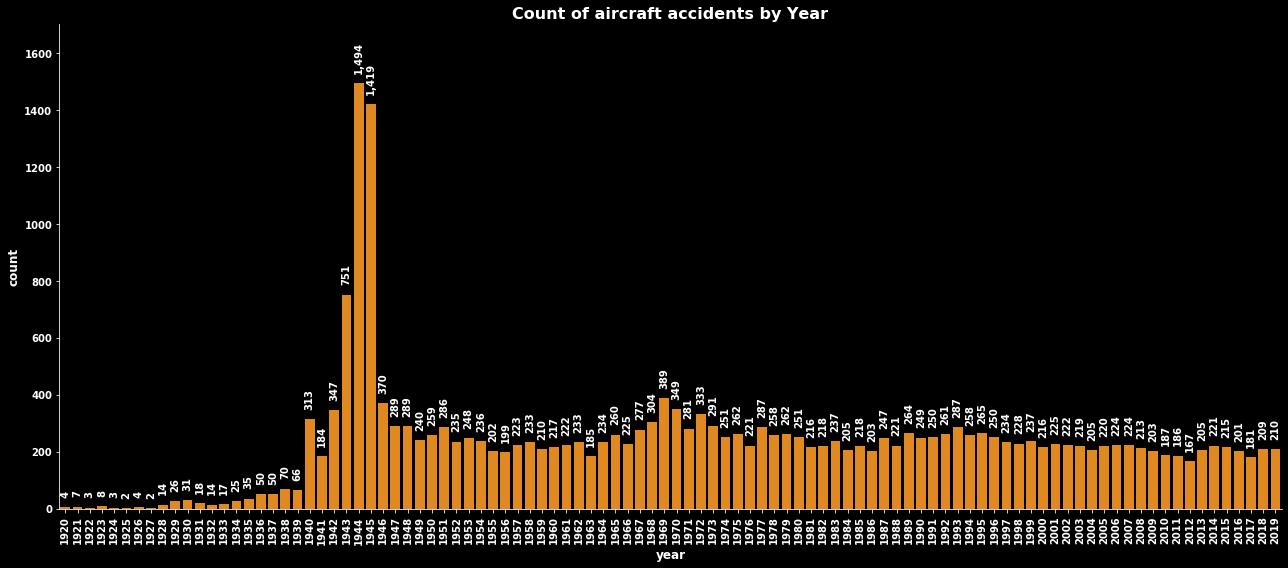

In [33]:
plot_countplot(
    df, 
    'year', 
    hue_column=None, 
    figsize=(18, 8), 
    title='Count of aircraft accidents by Year',
    ylims=(0, 1700)
)

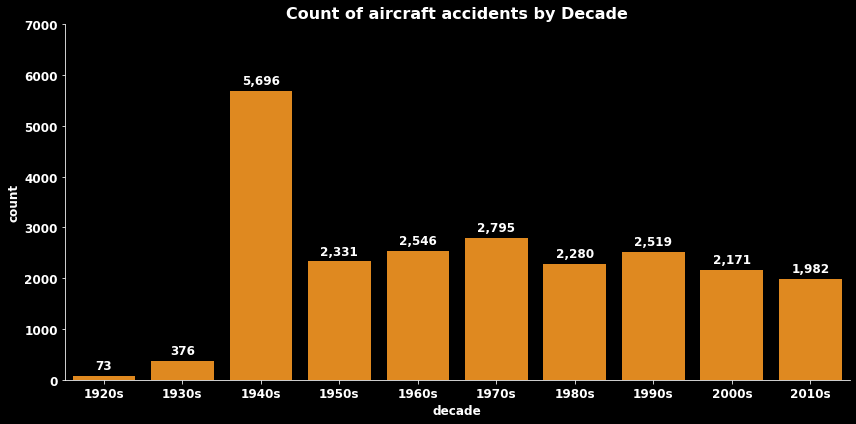

In [34]:
plot_countplot(
    df.sort_values(by='decade'), 
    'decade', 
    figsize=(12, 6), 
    title='Count of aircraft accidents by Decade',
    ylims=(0, 7000),
    ticks_rotation=0,
    ticks_fontsize=12
)

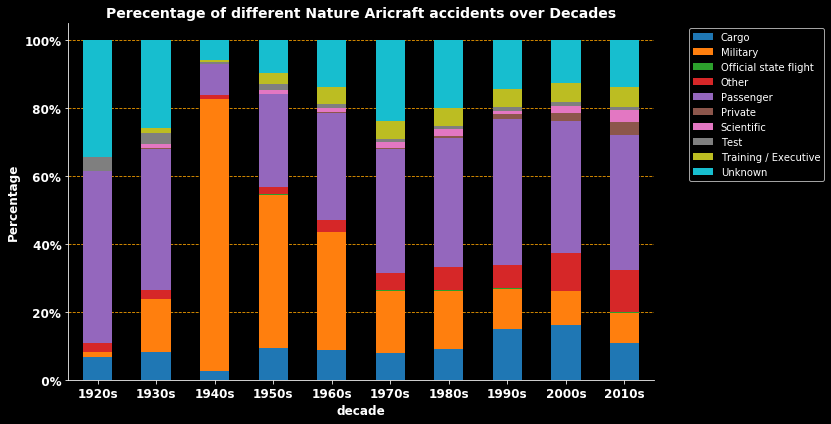

In [35]:
temp = df.groupby(by=['decade'])['nature_group'].apply(
    lambda x: x.value_counts() / len(x)).unstack()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
plt.title(
    'Perecentage of different Nature Aricraft accidents over Decades',
    fontsize=14, fontweight='bold'
)
temp.plot(ax=ax, kind='bar', stacked=True, rot=0,
          color=sns.color_palette('tab10', n_colors=10))
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in vals])
ax.set_axisbelow(True)
sns.despine()
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.xlabel('decade', fontsize=12, fontweight='bold')
plt.ylabel('Percentage', fontsize=12, fontweight='bold')

plt.grid(True, axis='y', linestyle='--', color='orange')
plt.tight_layout()

plt.show()

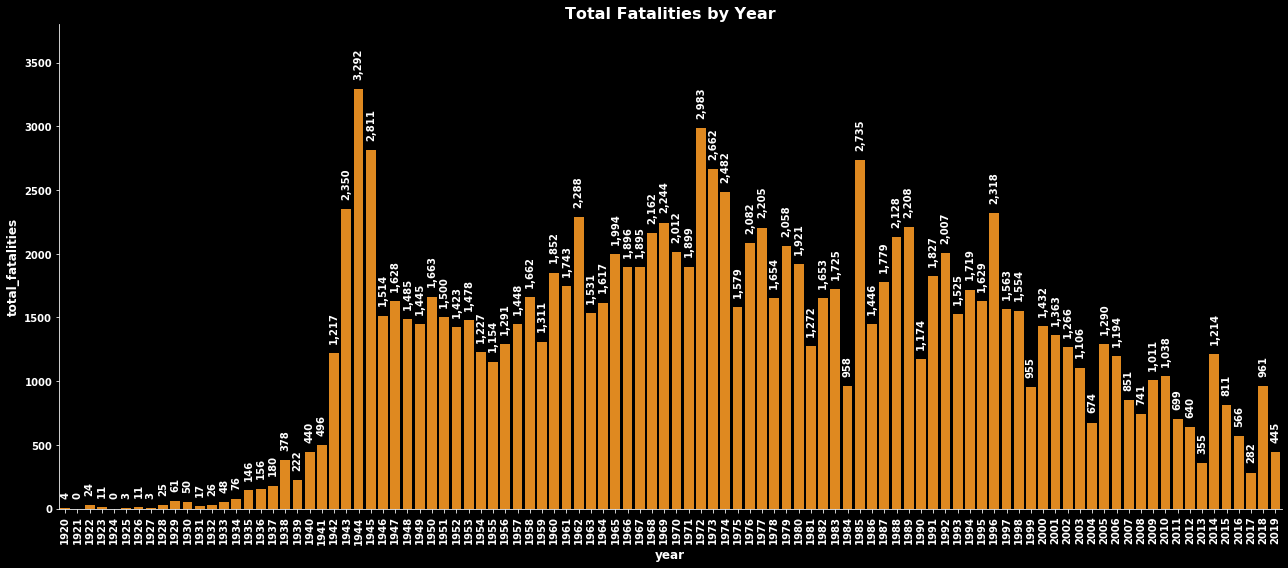

In [40]:
plot_aggregated_barplot(
    df,
    'year',
    'total_fatalities',
    aggregation_type='sum',
    figsize=(18, 8),
    title='Total Fatalities by Year',
    ylims=(0, 3800)
)

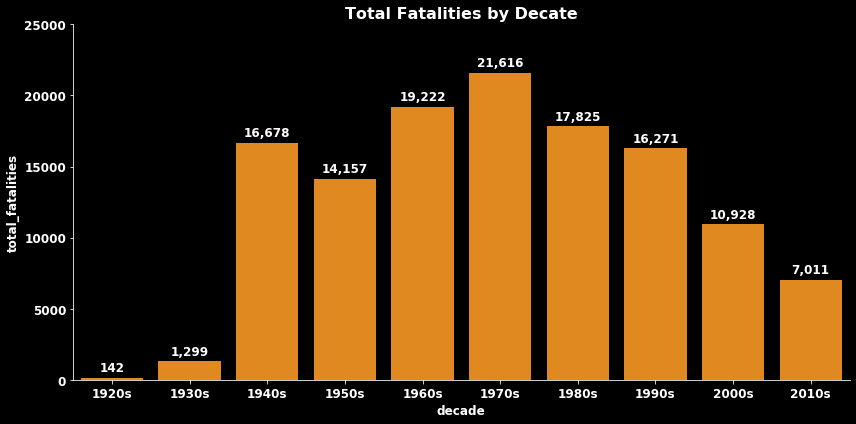

In [41]:
plot_aggregated_barplot(
    df,
    'decade',
    'total_fatalities',
    aggregation_type='sum',
    figsize=(12, 6),
    title='Total Fatalities by Decate',
    ylims=(0, 25000),
    ticks_rotation=0,
    ticks_fontsize=12
)

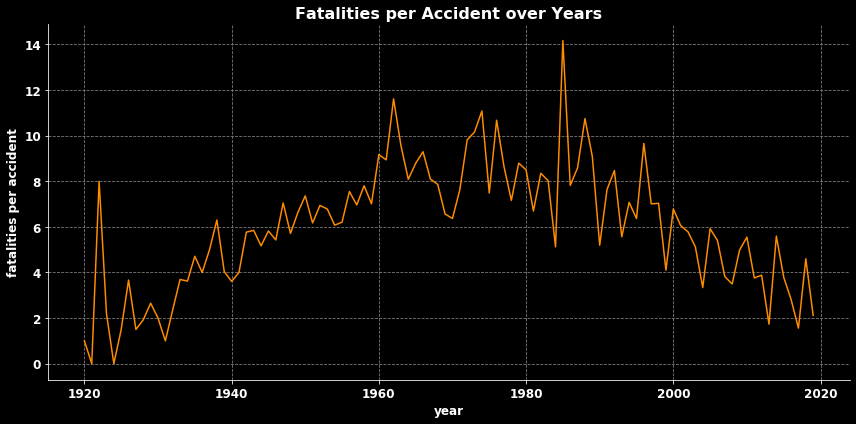

In [38]:
temp = df[pd.notna(df['total_fatalities'])].groupby('year').agg({'total_fatalities': ('sum', 'count')})
temp.columns = ['_'.join(c).strip() for c in temp.columns]
temp = temp.reset_index()
temp['fatalities per accident'] = temp['total_fatalities_sum'] / temp['total_fatalities_count']
plot_lineplot(
    temp,
    'year',
    'fatalities per accident',
    figsize=(12, 6),
    title='Fatalities per Accident over Years',
    ticks_rotation=0,
    ticks_fontsize=12
    
)

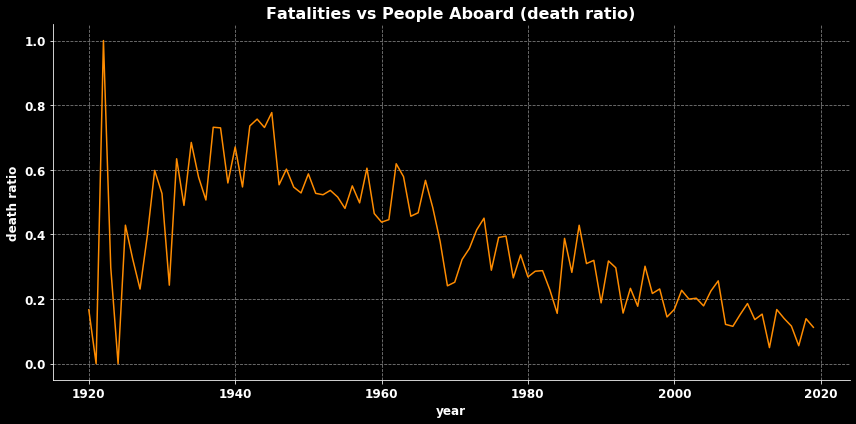

In [39]:
temp = df[pd.notna(df['total_fatalities'])].groupby('year').agg(
    {'total_fatalities': 'sum', 'total_occupants': 'sum'}
)
temp = temp.reset_index()
temp['death ratio'] = temp['total_fatalities'] / temp['total_occupants']
plot_lineplot(
    temp,
    'year',
    'death ratio',
    figsize=(12, 6),
    title='Fatalities vs People Aboard (death ratio)',
    ticks_rotation=0,
    ticks_fontsize=12
)

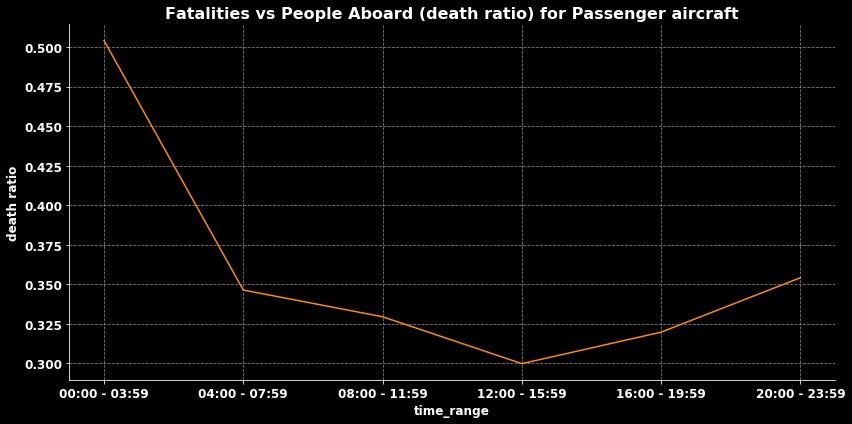

In [42]:
temp = df[pd.notna(df['total_fatalities'])].groupby('time_range').agg(
    {'total_fatalities': 'sum', 'total_occupants': 'sum'}
)
temp = temp.reset_index()
temp['death ratio'] = temp['total_fatalities'] / temp['total_occupants']
plot_lineplot(
    temp,
    'time_range',
    'death ratio',
    figsize=(12, 6),
    title='Fatalities vs People Aboard (death ratio) for Passenger aircraft',
    ticks_rotation=0,
    ticks_fontsize=12
)

### Passanger Aircraft

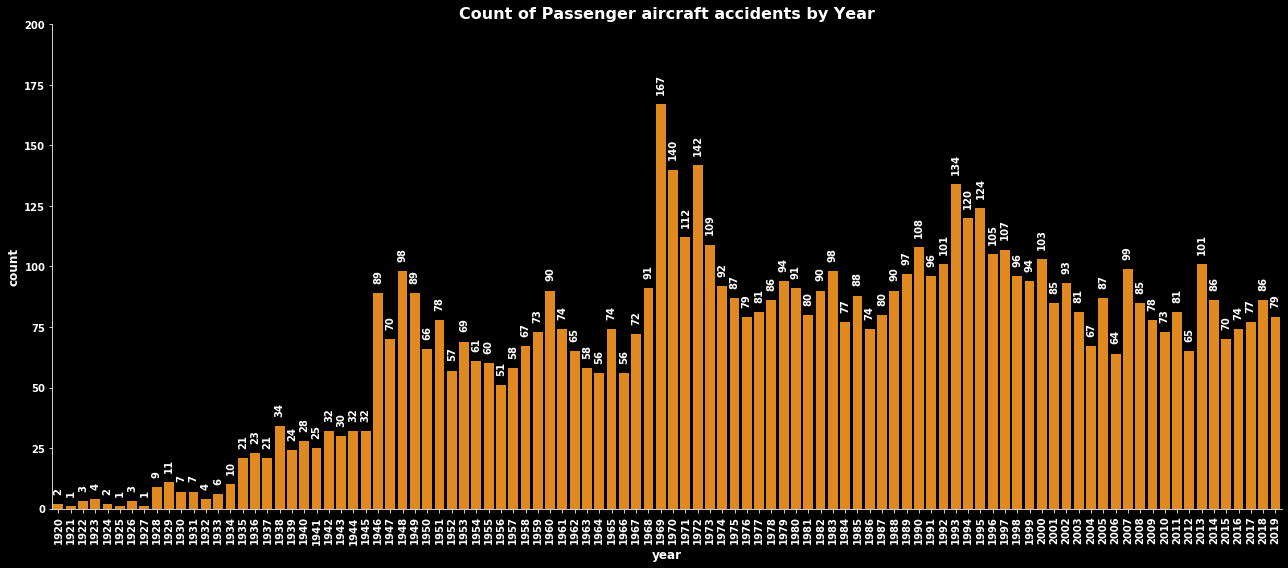

In [43]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'], 
    'year', 
    figsize=(18, 8), 
    title='Count of Passenger aircraft accidents by Year',
    ylims=(0, 200)
)

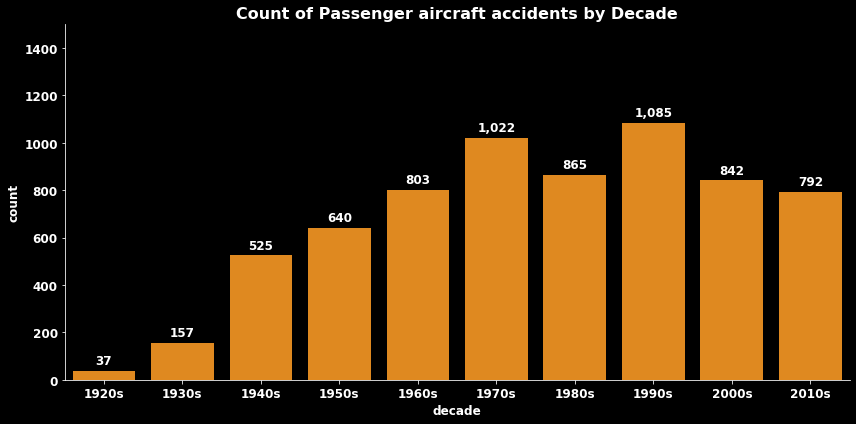

In [44]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'].sort_values(by='decade'), 
    'decade', 
    figsize=(12, 6), 
    title='Count of Passenger aircraft accidents by Decade',
    ylims=(0, 1500),
    ticks_rotation=0,
    ticks_fontsize=12
)

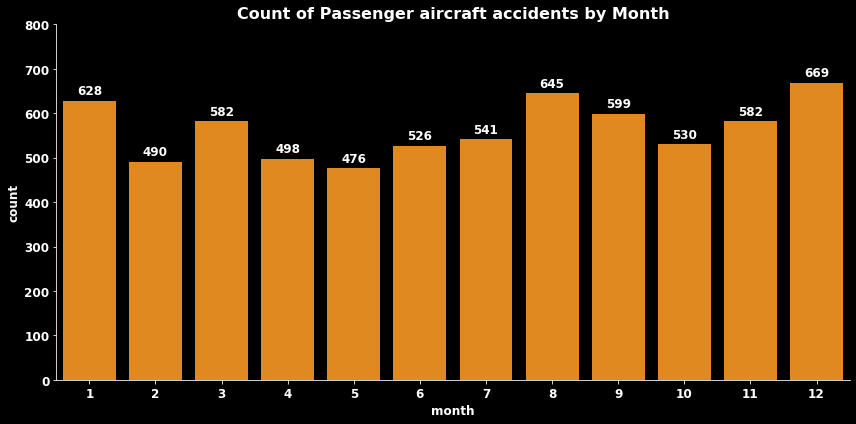

In [45]:
temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['month'])]
temp['month'] = temp['month'].astype(int)
plot_countplot(
    temp, 
    'month', 
    figsize=(12, 6), 
    title='Count of Passenger aircraft accidents by Month',
    ylims=(0, 800),
    ticks_rotation=0,
    ticks_fontsize=12
)

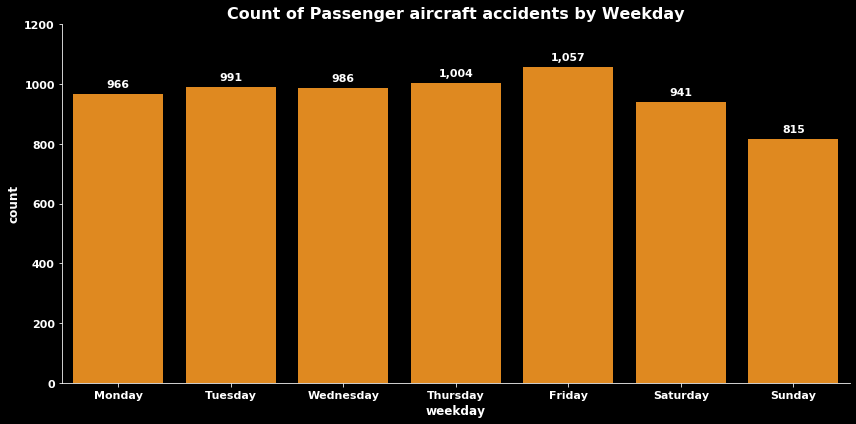

In [46]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'].sort_values(by='weekday'), 
    'weekday', 
    figsize=(12, 6), 
    title='Count of Passenger aircraft accidents by Weekday',
    ylims=(0, 1200),
    ticks_rotation=0,
    ticks_fontsize=11
)

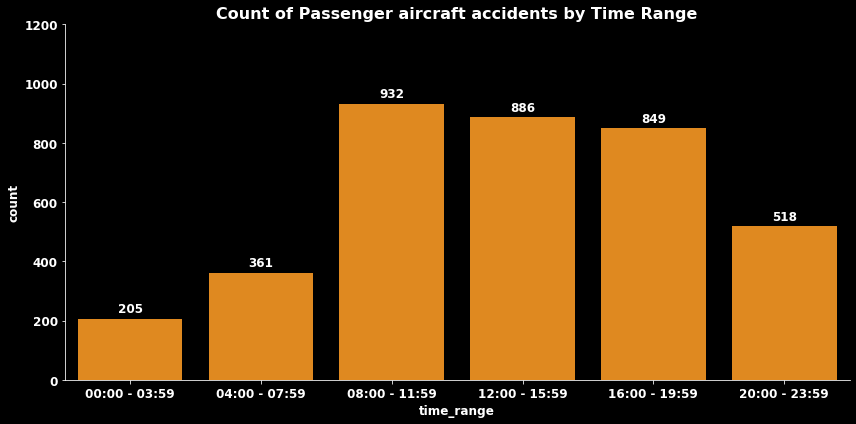

In [47]:
plot_countplot(
    df[df['nature_group'] == 'Passenger'].sort_values(by='time_range'), 
    'time_range', 
    figsize=(12, 6), 
    title='Count of Passenger aircraft accidents by Time Range',
    ylims=(0, 1200),
    ticks_rotation=0,
    ticks_fontsize=12
)

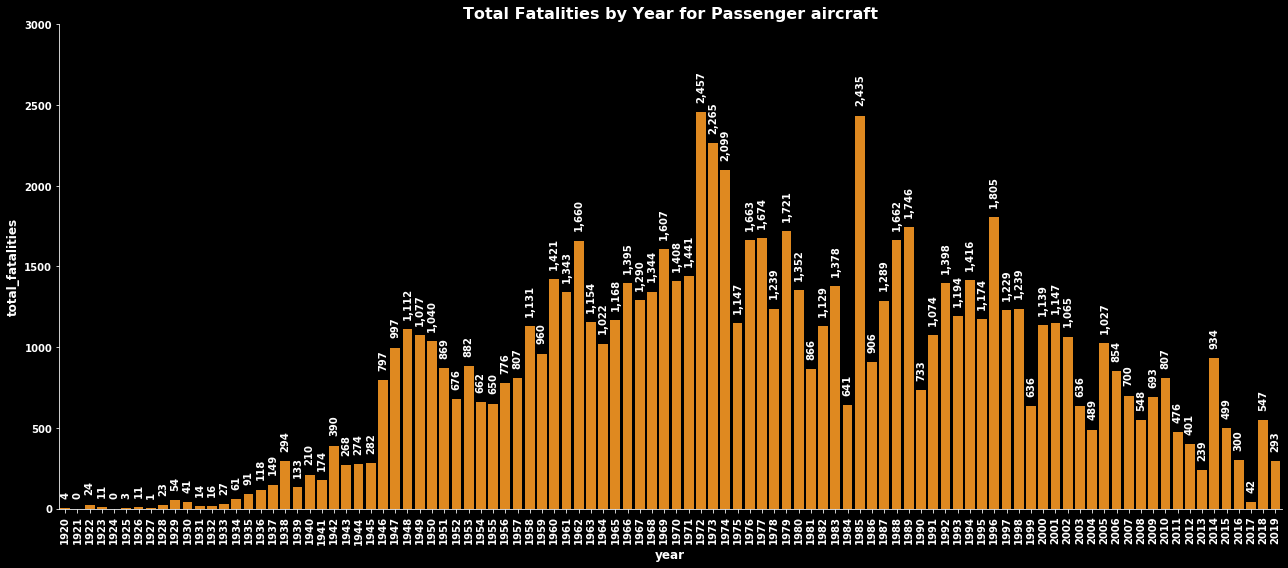

In [48]:
plot_aggregated_barplot(
    df[df['nature_group'] == 'Passenger'],
    'year',
    'total_fatalities',
    aggregation_type='sum',
    figsize=(18, 8),
    title='Total Fatalities by Year for Passenger aircraft',
    ylims=(0, 3000)
)

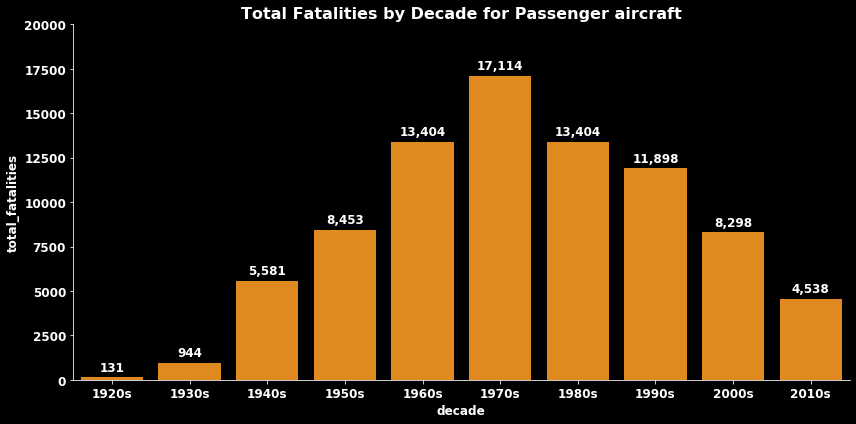

In [49]:
plot_aggregated_barplot(
    df[df['nature_group'] == 'Passenger'],
    'decade',
    'total_fatalities',
    aggregation_type='sum',
    figsize=(12, 6),
    title='Total Fatalities by Decade for Passenger aircraft',
    ylims=(0, 20000),
    ticks_rotation=0,
    ticks_fontsize=12
)

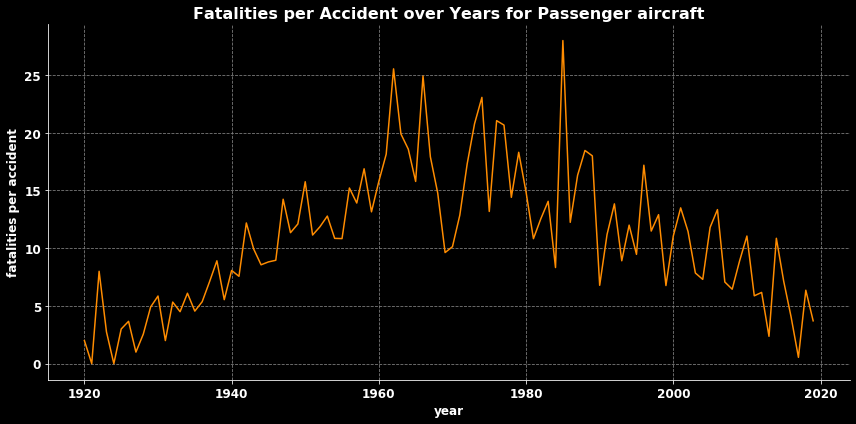

In [50]:
temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['total_fatalities'])].groupby('year').agg({'total_fatalities': ('sum', 'count')})
temp.columns = ['_'.join(c).strip() for c in temp.columns]
temp = temp.reset_index()
temp['fatalities per accident'] = temp['total_fatalities_sum'] / temp['total_fatalities_count']
plot_lineplot(
    temp,
    'year',
    'fatalities per accident',
    figsize=(12, 6),
    title='Fatalities per Accident over Years for Passenger aircraft',
    ticks_rotation=0,
    ticks_fontsize=12
)

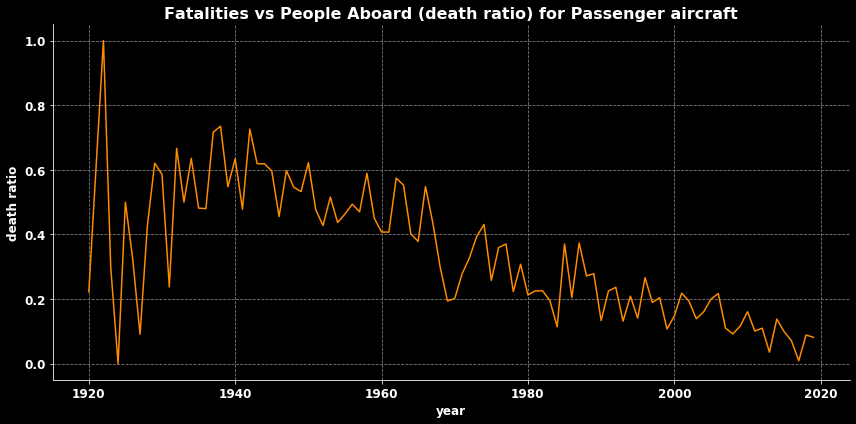

In [51]:
temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['total_fatalities'])].groupby('year').agg(
    {'total_fatalities': 'sum', 'total_occupants': 'sum'}
)
temp = temp.reset_index()
temp['death ratio'] = temp['total_fatalities'] / temp['total_occupants']
plot_lineplot(
    temp,
    'year',
    'death ratio',
    figsize=(12, 6),
    title='Fatalities vs People Aboard (death ratio) for Passenger aircraft',
    ticks_rotation=0,
    ticks_fontsize=12
)

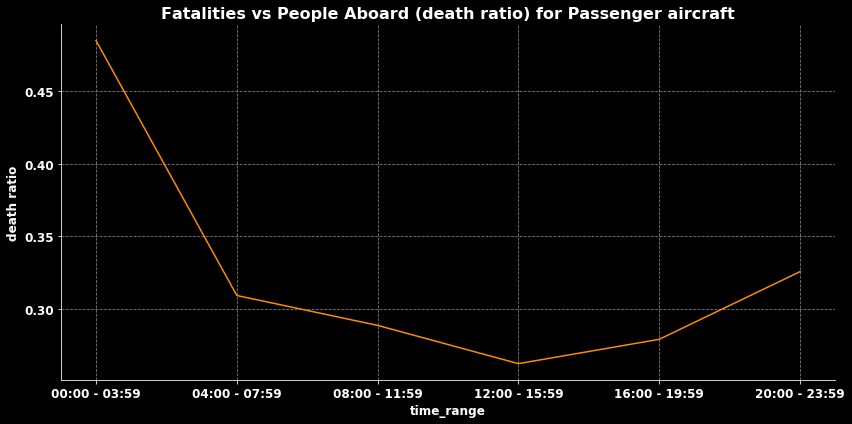

In [52]:
temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['total_fatalities'])].groupby('time_range').agg(
    {'total_fatalities': 'sum', 'total_occupants': 'sum'}
)
temp = temp.reset_index()
temp['death ratio'] = temp['total_fatalities'] / temp['total_occupants']
plot_lineplot(
    temp,
    'time_range',
    'death ratio',
    figsize=(12, 6),
    title='Fatalities vs People Aboard (death ratio) for Passenger aircraft',
    ticks_rotation=0,
    ticks_fontsize=12
)

The first two plot shows air crash count in each year and fatality count and death ratio in each ten years. We can see that after 1970, total amount of accidents and people die from accidents are both decreasing. Due to lack of annually flights count data, we can't simply say that accident rate is decreasing. However, the death rate went down from over 90% to around 65% throughout history, which means passengers are more likely to survive than before in an air crash.
The third plot shows air crash death ratio by time of day. Number of air crash are distinguished by day and night. Again, due to data limitation, we can't conclude that at what time it has higher accident rate, but death rate during night is higher than during day.

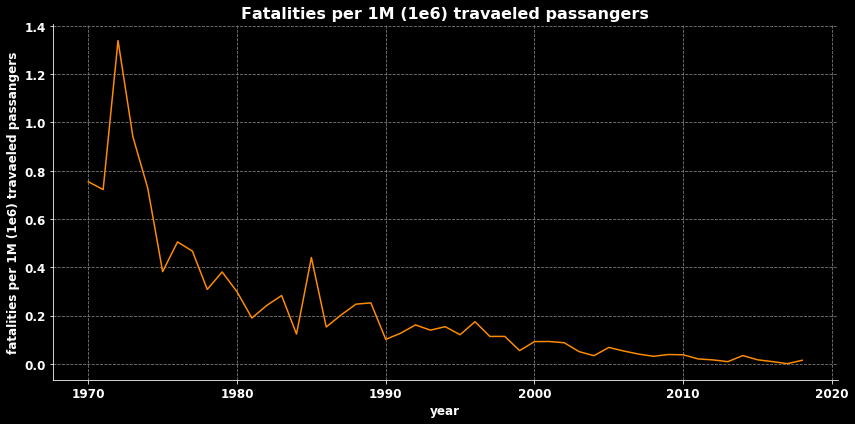

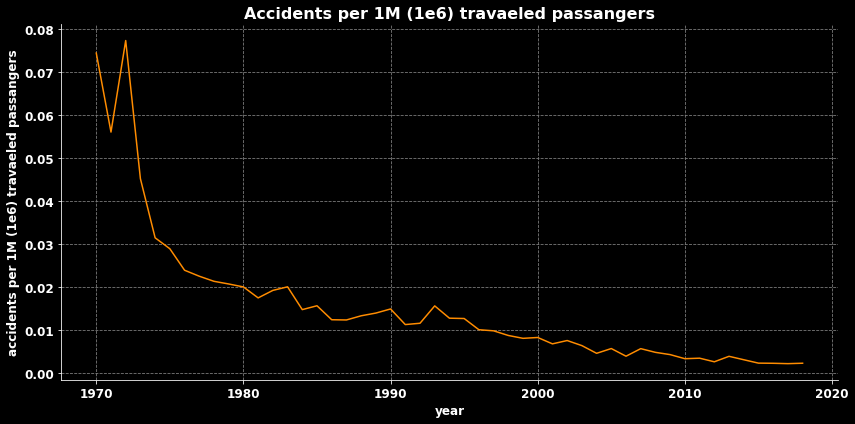

In [53]:
total_passengers = pd.read_csv('data/passengers_carried_from_worldbank.csv')
total_passengers = total_passengers.drop(
    ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis=1
)
total_passengers = total_passengers.replace(np.nan, 0)
total_passengers = pd.DataFrame(total_passengers.sum())
total_passengers = total_passengers.reset_index()
total_passengers.columns = ['year', 'total_traveled_passengers']
total_passengers = total_passengers[total_passengers['total_traveled_passengers'] > 0]
total_passengers['year'] = total_passengers['year'].map(int)



temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['total_fatalities'])].groupby('year').agg({'total_fatalities': ('sum', 'count')})
temp.columns = ['_'.join(c).strip() for c in temp.columns]
temp = temp.reset_index()
temp = temp.merge(total_passengers)
temp['fatalities per 1M (1e6) travaeled passangers'] = (
    temp['total_fatalities_sum'] / temp['total_traveled_passengers'] * 1e6
)
temp['accidents per 1M (1e6) travaeled passangers'] = (
    temp['total_fatalities_count'] / temp['total_traveled_passengers'] * 1e6
)

plot_lineplot(
    temp,
    'year',
    'fatalities per 1M (1e6) travaeled passangers',
    figsize=(12, 6),
    title='Fatalities per 1M (1e6) travaeled passangers',
    ticks_rotation=0,
    ticks_fontsize=12
    
)

plot_lineplot(
    temp,
    'year',
    'accidents per 1M (1e6) travaeled passangers',
    figsize=(12, 6),
    title='Accidents per 1M (1e6) travaeled passangers',
    ticks_rotation=0,
    ticks_fontsize=12
    
)

## Flight Phase

In [70]:
# TODO remove last 3 letters, sort by actual phase

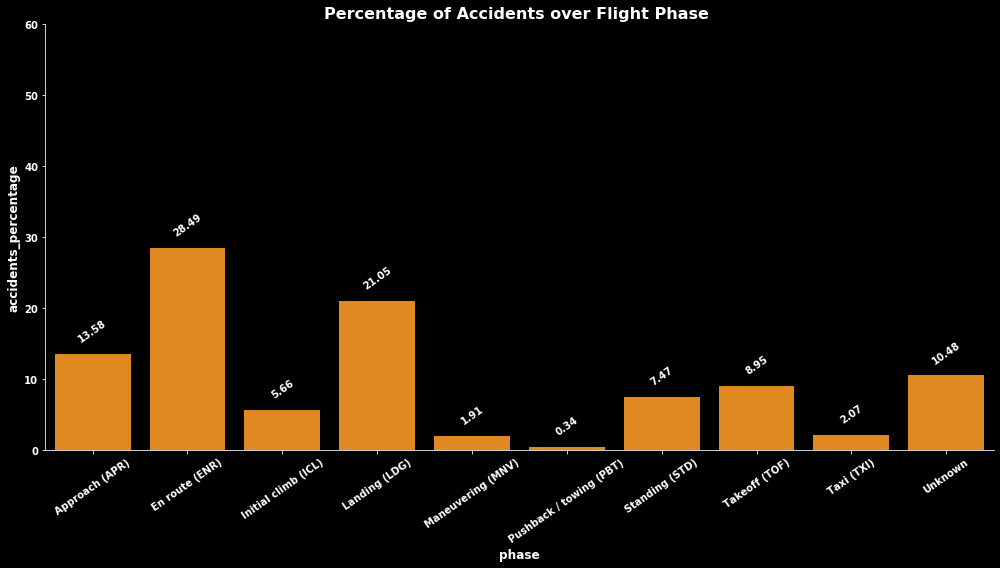

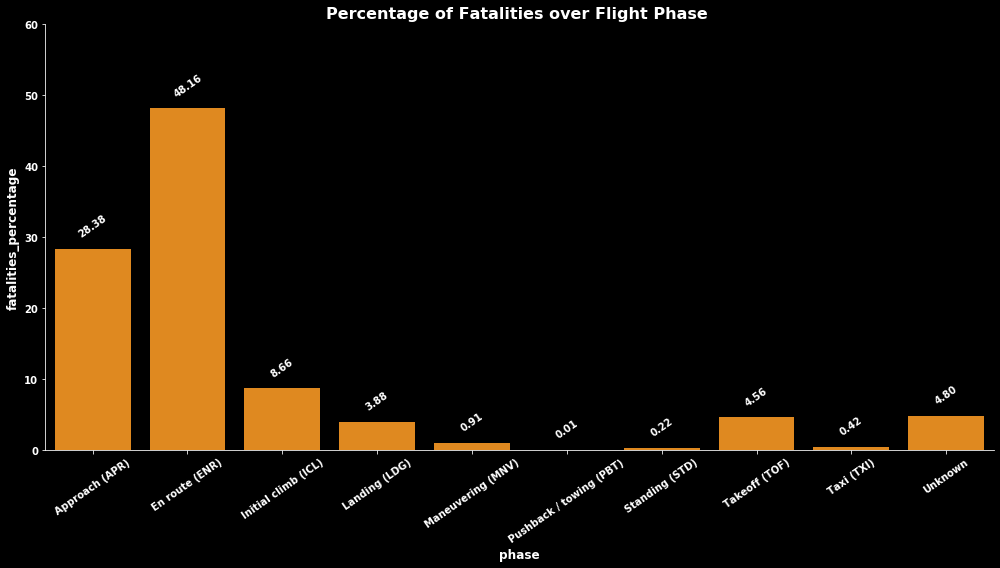

In [66]:
temp = df[pd.notna(df['total_fatalities'])].groupby('phase').agg({'total_fatalities': ('sum', 'count')})
temp.columns = ['_'.join(c).strip() for c in temp.columns]
temp = temp.reset_index()
temp['fatalities_percentage'] = temp['total_fatalities_sum'] / temp['total_fatalities_sum'].sum() * 100
temp['accidents_percentage'] = temp['total_fatalities_count'] / temp['total_fatalities_count'].sum() * 100


plot_aggregated_barplot(
    temp, 
    x_column='phase',
    y_column='accidents_percentage',
    annotation_precision=2,
    ylims=(0, 60), 
    ticks_rotation=35,
    title='Percentage of Accidents over Flight Phase '
)
plot_aggregated_barplot(
    temp, 
    x_column='phase',
    y_column='fatalities_percentage',
    annotation_precision=2,
    ylims=(0, 60), 
    ticks_rotation=35,
    title='Percentage of Fatalities over Flight Phase '
)

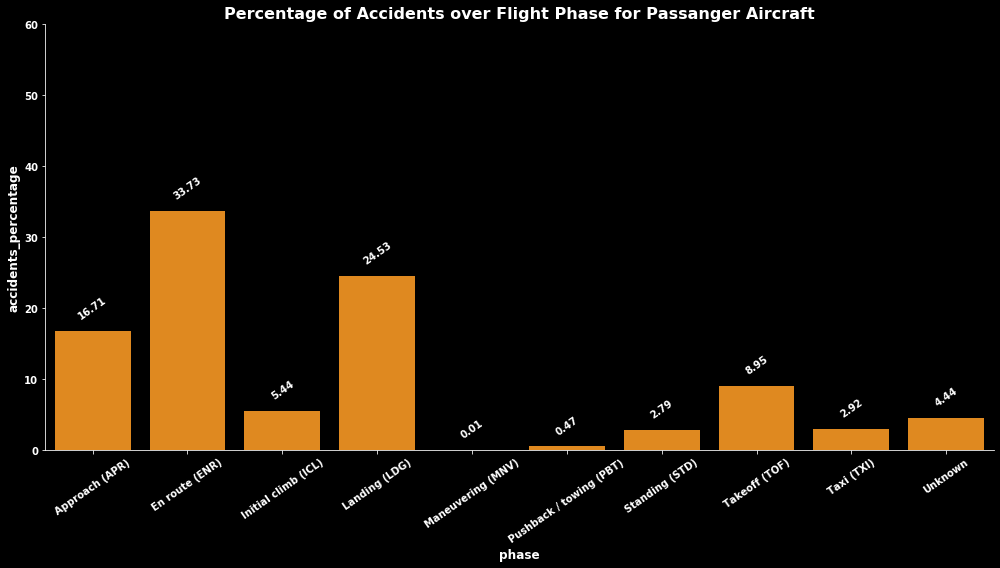

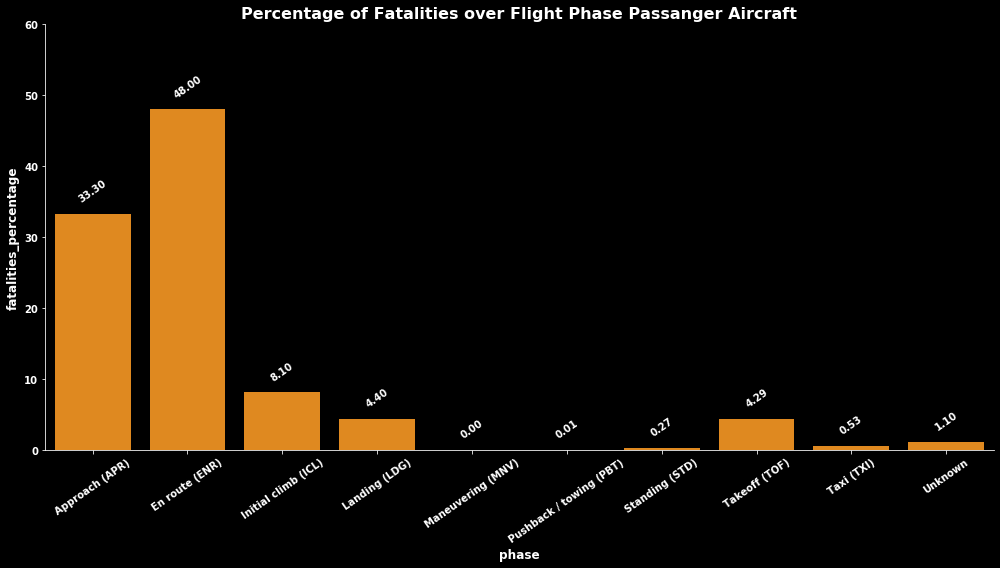

In [67]:
temp = df[df['nature_group'] == 'Passenger']
temp = temp[pd.notna(temp['total_fatalities'])].groupby('phase').agg({'total_fatalities': ('sum', 'count')})
temp.columns = ['_'.join(c).strip() for c in temp.columns]
temp = temp.reset_index()
temp['fatalities_percentage'] = temp['total_fatalities_sum'] / temp['total_fatalities_sum'].sum() * 100
temp['accidents_percentage'] = temp['total_fatalities_count'] / temp['total_fatalities_count'].sum() * 100


plot_aggregated_barplot(
    temp, 
    x_column='phase',
    y_column='accidents_percentage',
    annotation_precision=2,
    ylims=(0, 60), 
    ticks_rotation=35,
    title='Percentage of Accidents over Flight Phase for Passanger Aircraft'
)
plot_aggregated_barplot(
    temp, 
    x_column='phase',
    y_column='fatalities_percentage',
    annotation_precision=2,
    ylims=(0, 60), 
    ticks_rotation=35,
    title='Percentage of Fatalities over Flight Phase Passanger Aircraft'
)